<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План проекта:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# импортируем библиотеки 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
display(data.head())
data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [3]:
data.set_index(data['datetime'], inplace=True)
data.drop('datetime', axis=1, inplace=True)
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
display(data.index.is_monotonic)

True

In [5]:
data = data.resample('1H').sum()
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод:**

* Открыли данные.
* Задали поле datetime как индекс.
* Проверили datetime  на монотонное возрастание.
* Провели ресемплирование данных.
* Подготовили данные для дальнейшего анализа.

## Анализ

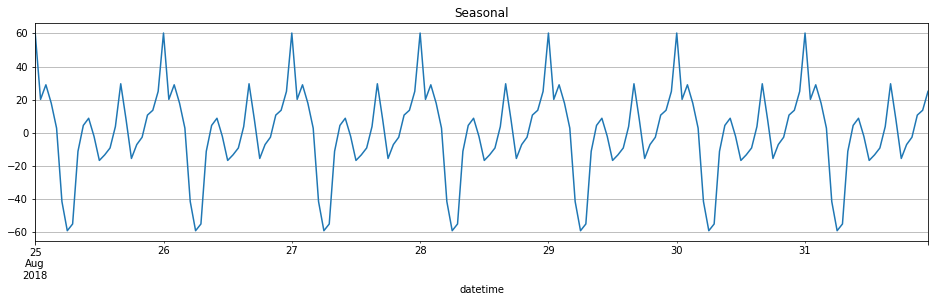

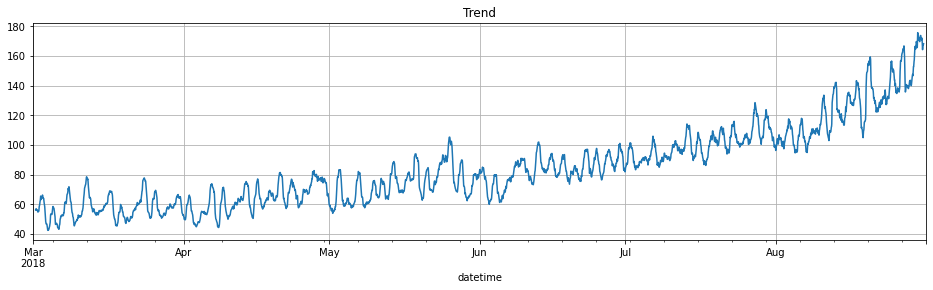

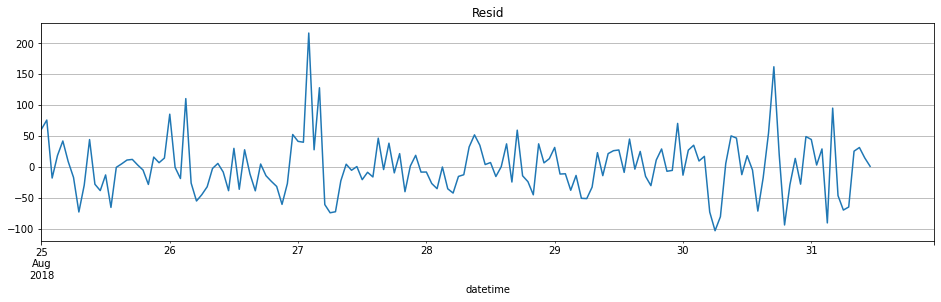

In [6]:
# рассмотрим тренд, сезонность и остатки
decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-08-25':'2018-08-31'].plot(figsize=(16,4), grid=True, title='Seasonal')
plt.show()
decomposed.trend.plot(figsize=(16,4), grid=True, title='Trend')
plt.show()
decomposed.resid['2018-08-25':'2018-08-31'].plot(figsize=(16,4), grid=True, title='Resid')
plt.show()


* Наблюдается тренд на увеличение заказов в течение года.

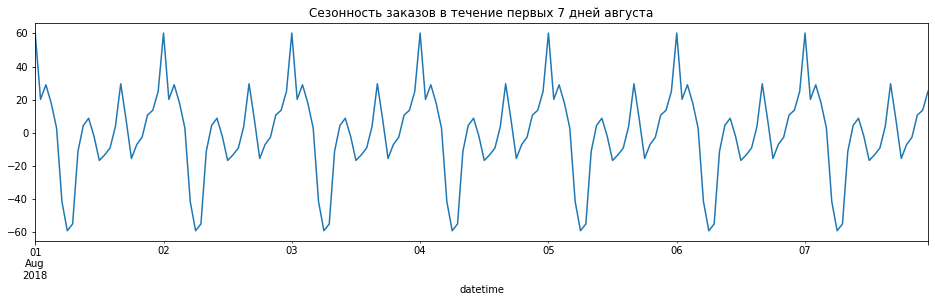

In [7]:
# рассмотим сезонность заказов на отдельном примере (возьмем первую неделю августа)
plt.figure(figsize=(16,4))
plt.title("Сезонность заказов в течение первых 7 дней августа")
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca());

* Наблюдаем каждодневную сезонность заказов

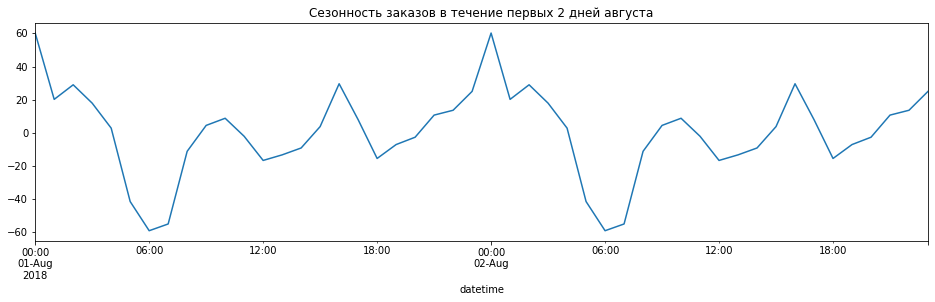

In [8]:
# рассмотрим сезонность на примере пары дней
plt.figure(figsize=(16,4))
plt.title("Сезонность заказов в течение первых 2 дней августа")
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca());

* Наблюдаем пик заказов полночь и спад заказов в 6 утра.


* На данном этапе мы выяснили, что наблюдается тренд в заказах на увеличение в течении года. Сезонность заказов в пике приходящееся на полночь и спада в 6 утра.
* По полученным данным явно наличие увеличения заказов в течении года и ближе к полуночи. Уже сейчас мы можем с уверенностью сказать, что заказов увеличивается в 10 утра, 17 вечера и растет с 18 вечера до полуночи.

In [9]:
def data_an(data, column):
    sns.distplot(data[column])
    plt.show()
    sns.boxplot(x=data[column])
    plt.show()
    print(data.describe())

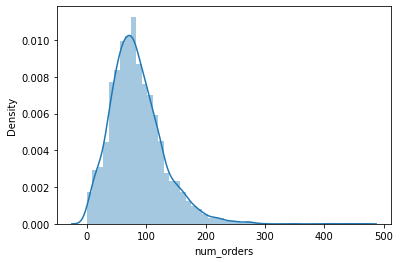

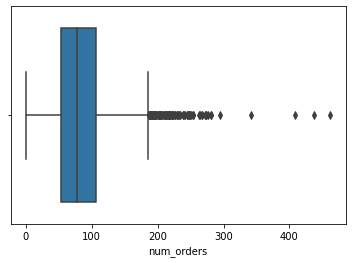

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


In [10]:
data_an(data, 'num_orders')

* Видим, что среднее значение меняется и отклонение зависит от времени, что говорит о нестационарности времянного ряда.

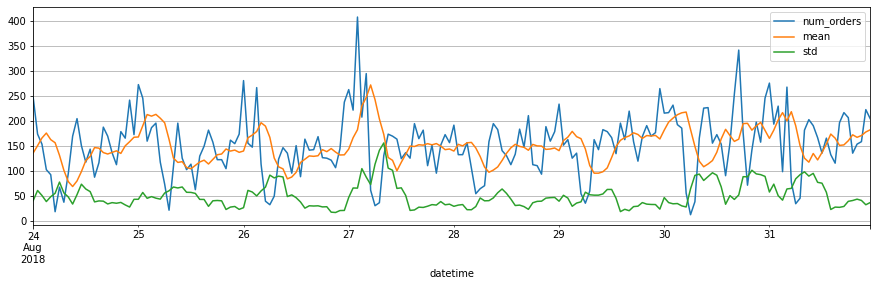

In [11]:
data['mean'] = data['num_orders'].rolling(6, closed= "left").mean()
data['std'] = data['num_orders'].rolling(6, closed= "left").std()
data['2018-08-24':'2018-08-31'].plot(figsize=(15,4), grid=True)
plt.show()

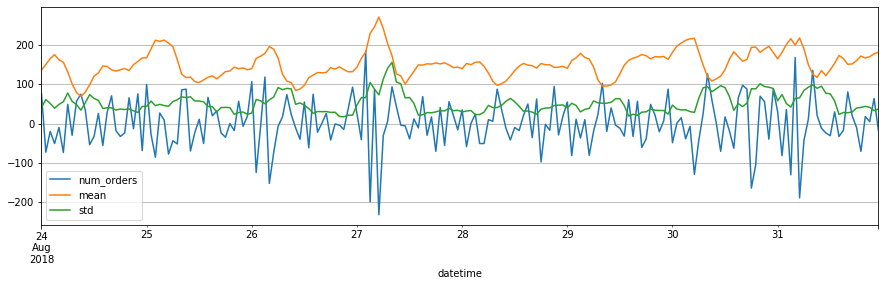

In [13]:
data1 = data.copy()
data1['num_orders'] = data1['num_orders'] - data1['num_orders'].shift()
data1.dropna(inplace=True)
data1['mean'] = data['num_orders'].rolling(6, closed= "left").mean()
data1['std'] = data['num_orders'].rolling(6, closed= "left").std()
data1['2018-08-24':'2018-08-31'].plot(figsize=(15,4), grid=True)
plt.show()

* Приведя график к разностям ряда, мы добились более стационарных показателей, что в дальнейшем скажется на качестве моделей.

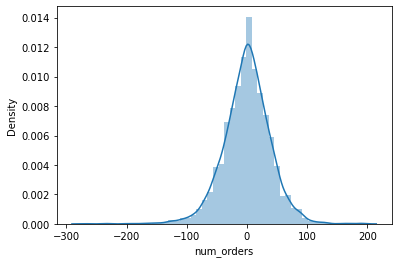

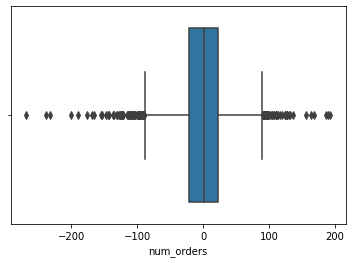

        num_orders         mean          std
count  4410.000000  4410.000000  4410.000000
mean      0.045125    84.338473    30.055782
std      39.034962    32.925423    14.833466
min    -269.000000    18.500000     4.708149
25%     -22.000000    61.875000    20.298809
50%       1.000000    79.000000    27.009875
75%      23.000000   102.166667    36.597017
max     193.000000   272.333333   160.528710


In [14]:
data_an(data1, 'num_orders')

* Мы сделали временной ряд станционарным. Среднее не меняется, отклонение не зависит от времени.

## Обучение

In [15]:
data.drop(['mean', 'std'], axis=1, inplace=True)

In [16]:
def make_features(df, max_lag, rolling_mean_size):
    new_df = df.copy()
    new_df['month'] = df.index.month
    new_df['day'] = df.index.day
    new_df['dayofweek'] = df.index.dayofweek
    new_df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        new_df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    new_df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = train_test_split(new_df, shuffle=False, test_size=0.1)
    train.dropna(inplace=True)
    
    features_train = train.drop('num_orders', axis=1)
    target_train = train['num_orders']
    features_test = test.drop('num_orders', axis=1)
    target_test = test['num_orders']
    return features_train, features_test, target_train, target_test

In [17]:
display(data.shape)
features_train, features_test, target_train, target_test = make_features(data, 1, 1)
display(features_train.shape, features_train.index.min(), features_train.index.max())
display(features_test.shape, features_test.index.min(), features_test.index.max())

(4416, 1)

(3973, 6)

Timestamp('2018-03-01 01:00:00', freq='H')

Timestamp('2018-08-13 13:00:00', freq='H')

(442, 6)

Timestamp('2018-08-13 14:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

In [18]:
result = pd.DataFrame(columns = ['RMSE_CV', 'Lag', 'Rolling_Mean', 'Params'])
def data_result(model_name, rmse, lag, rm_size, params, df):
    df.loc[model_name, 'RMSE_CV'] = round(rmse,4)
    df.loc[model_name, 'Lag'] = int(lag)
    df.loc[model_name, 'Rolling_Mean'] = int(rm_size)
    df.loc[model_name, 'Params'] = params
    return df

In [19]:
def model_train(model, params, df, max_lag, max_rm_size):
    start = time.time()
    tss = TimeSeriesSplit(n_splits=3)
    best_lag = 0
    best_rm_size = 0
    best_rmse = 0
    best_mse = 10**5
    for lag in range(1,max_lag):
        for rm_size in range(2,max_rm_size):
            features_train, features_test, target_train, target_test = make_features(df, lag, rm_size)
            grid = (GridSearchCV(model,
                                 param_grid=params,
                                 scoring='neg_mean_squared_error',
                                 cv=tss,
                                 n_jobs=-1
                                )
                 ).fit(features_train, target_train)
            if -grid.best_score_ < best_mse:
                best_mse = -grid.best_score_
                best_lag = lag
                best_rm_size = rm_size
                best_rmse = best_mse**0.5
                best_params = grid.best_params_
    end = time.time()
    print('Время CV', round(end-start, 4))
    return best_rmse, best_lag, best_rm_size, best_params

In [20]:
LR = LinearRegression()
LR_params = {'normalize': [True, False]
            }
best_rmse, best_lag, best_rm_size, best_params = model_train(LR, LR_params, data, 5, 15)
display(data_result('LR', best_rmse, best_lag, best_rm_size, best_params.items(), result))

Время CV 4.1832


,RMSE_CV,Lag,Rolling_Mean,Params
LR,32.6124,2,4,"((normalize, False))"


In [21]:
DTR = DecisionTreeRegressor()
DTR_params = {'max_depth' : range(2, 21, 3),
              'min_samples_leaf' : range (1,16,2),
              'random_state' : [12345]
             }
best_rmse, best_lag, best_rm_size, best_params = model_train(DTR, DTR_params, data, 5, 15)
display(data_result('DTR', best_rmse, best_lag, best_rm_size, best_params.items(), result))

Время CV 71.6568


,RMSE_CV,Lag,Rolling_Mean,Params
LR,32.6124,2,4,"((normalize, False))"
DTR,28.2771,1,13,"((max_depth, 11), (min_samples_leaf, 7), (rand..."


In [22]:
LGBMR = LGBMRegressor()
LGBMR_params = {'n_estimators':range(38, 42, 1)}
best_rmse, best_lag, best_rm_size, best_params = model_train(LGBMR, LGBMR_params, data, 5, 15)
display(data_result('LGBMR', best_rmse, best_lag, best_rm_size, best_params.items(), result))

Время CV 183.5984


,RMSE_CV,Lag,Rolling_Mean,Params
LR,32.6124,2,4,"((normalize, False))"
DTR,28.2771,1,13,"((max_depth, 11), (min_samples_leaf, 7), (rand..."
LGBMR,26.7204,3,13,"((n_estimators, 41))"


* Считаю, что с подбором фичей и гиперпараметров моделей можно заканчивать. На кросс-валидации получили метрики RSME < 48. Осталось протестировать.

## Тестирование

In [23]:
def model_test(model_name, mod, df_data, df_result):
    model = mod(**dict(df_result.loc[model_name, 'Params']))
    features_train, features_test, target_train, target_test = make_features(
        df_data, df_result.loc[model_name, 'Lag'], df_result.loc[model_name, 'Rolling_Mean']
    )
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    df_result.loc[model_name, 'RMSE_test'] = round(mean_squared_error(target_test, predictions)**0.5,4)
    
    plt.figure(figsize=(15,5))
    plt.title('Сравнение реальных значений и предсказанных')

    plt.plot(target_test.index, predictions, 'r', label='Предсказания')
    plt.plot(target_test.index, target_test.values, 'g', label='Реальные значения')
    plt.legend(loc="upper left")
    plt.grid(True)
    
    return df_result

,RMSE_CV,Lag,Rolling_Mean,Params,RMSE_test
LR,32.6124,2,4,"((normalize, False))",52.5619
DTR,28.2771,1,13,"((max_depth, 11), (min_samples_leaf, 7), (rand...",NaN
LGBMR,26.7204,3,13,"((n_estimators, 41))",NaN


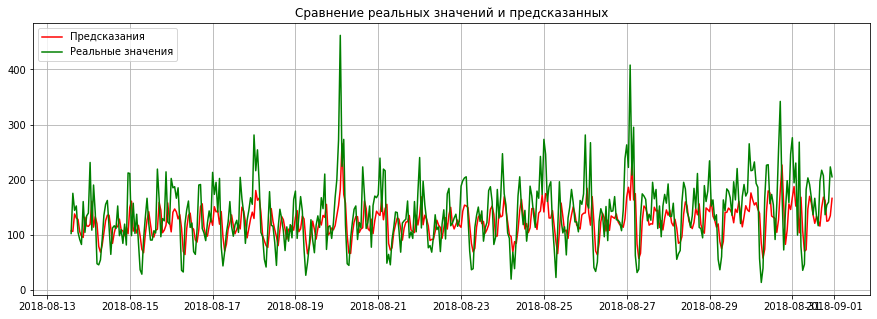

In [24]:
display(model_test('LR', LinearRegression, data, result))

,RMSE_CV,Lag,Rolling_Mean,Params,RMSE_test
LR,32.6124,2,4,"((normalize, False))",52.5619
DTR,28.2771,1,13,"((max_depth, 11), (min_samples_leaf, 7), (rand...",50.0534
LGBMR,26.7204,3,13,"((n_estimators, 41))",NaN


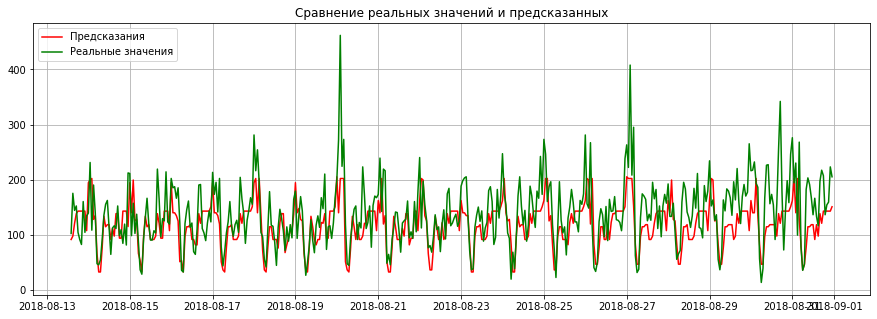

In [25]:
display(model_test('DTR', DecisionTreeRegressor, data, result))

,RMSE_CV,Lag,Rolling_Mean,Params,RMSE_test
LR,32.6124,2,4,"((normalize, False))",52.5619
DTR,28.2771,1,13,"((max_depth, 11), (min_samples_leaf, 7), (rand...",50.0534
LGBMR,26.7204,3,13,"((n_estimators, 41))",44.1744


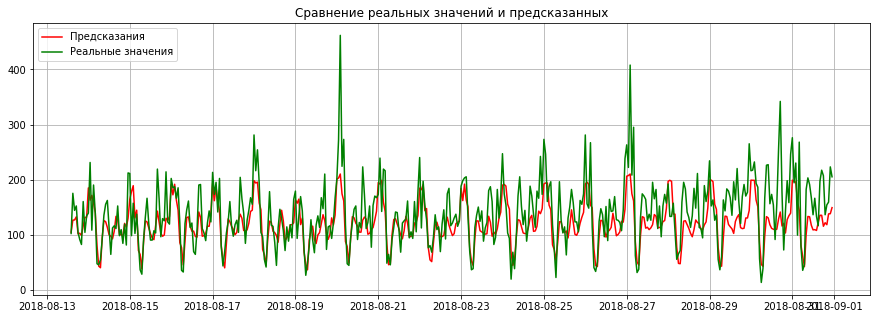

In [26]:
model = LGBMRegressor(max_depth=15, metric='rmse', n_estimators=120, objective='regression', random_state=12345)
features_train, features_test, target_train, target_test = make_features(
    data, result.loc['LGBMR', 'Lag'], result.loc['LGBMR', 'Rolling_Mean']
)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
result.loc['LGBMR', 'RMSE_test'] = round(mean_squared_error(target_test, predictions)**0.5,4)

display(model_test('LGBMR', LGBMRegressor, data, result))

In [27]:
features_train, features_test, target_train, target_test = make_features(data, 1, 10)
pred_median = np.ones(target_test.shape) * target_test.median()
rmse = round(mean_squared_error(target_test, pred_median)**0.5,4)
data_result('Median', 0, 1, 10, None, result)
result.loc['Median', 'RMSE_test'] = rmse
display(result)

,RMSE_CV,Lag,Rolling_Mean,Params,RMSE_test
LR,32.6124,2,4,"((normalize, False))",52.5619
DTR,28.2771,1,13,"((max_depth, 11), (min_samples_leaf, 7), (rand...",50.0534
LGBMR,26.7204,3,13,"((n_estimators, 41))",44.1744
Median,0,1,10,None,58.7266


## Общий вывод

* Мы подготовили данные.
* Преобразовали временной ряд в стационарный с помощью разности.
* Написали функции для подброа фичей и гиперпараметров моделей кросс-валидацией.
* Обучили 3 модели.
* Наши модели предсказывают лучше, чем медиана, соответственно, не зря их учили.
* Задание проекта выполнено - RMSE модели LGBMR меньше 48.